In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tools import make_visibilities_from_image, make_power_spectrum, calcvals
from plotting_func import plot_power_spectrum

from mpol.__init__ import zenodo_record
from mpol import coordinates, gridding, fourier, losses, precomposed, utils
from mpol.images import ImageCube

/Users/behzadbojnordiarbab/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


L
1324 1254


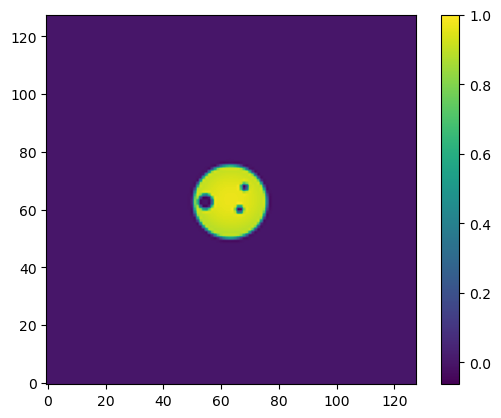

0.03 arcsec
128
0.0009 arcsec^2
0.39310333567573225 Jy
5.0 Jy
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]] Jy
5.0


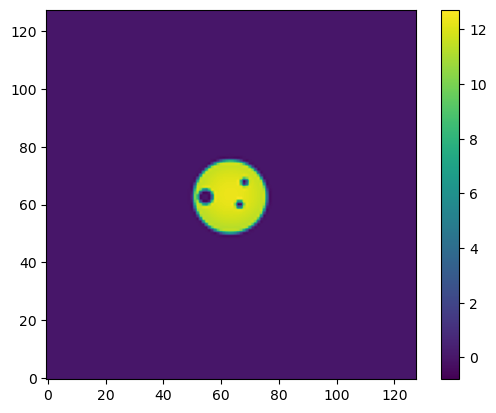

Dataset has 325080 visibilities
[   81.49899897     7.87458415   -52.21522451 ...  2219.99621332
  1180.43683531 -1039.55937801]
[   15.83280024    27.80872902   -44.83083149 ...   774.43215868
  -261.48392316 -1035.91608184]
[0.46612835 0.46612835 0.46612835 ... 0.46612835 0.46612835 0.46612835]
The maximum cell_size that will still Nyquist sample the spatial frequency represented by the maximum u,v value is 0.09 arcseconds


/Users/behzadbojnordiarbab/opt/anaconda3/lib/python3.9/site-packages/torchkbnufft/_nufft/spmat.py:101: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  torch.sparse.FloatTensor(inds, real_vals, torch.Size(shape)),  # type: ignore


(1, 325080)
(1, 325080)
[[ 4.86222071-0.76996164j  4.07159436+2.24516811j  6.98649909+1.03465229j
  ... -1.06581029+0.55798651j  1.93361686-3.52651384j
  -1.38500756+1.14229276j]]


In [3]:
# Creating fake visibilities from jpg image

image_file = '../data/star_images/circle_with_spots.jpg'
cell_size = 0.03
make_visibilities_from_image(image_file=image_file, cell_size=cell_size)

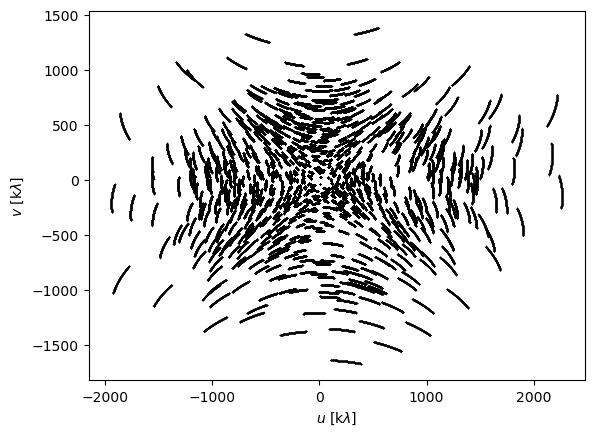

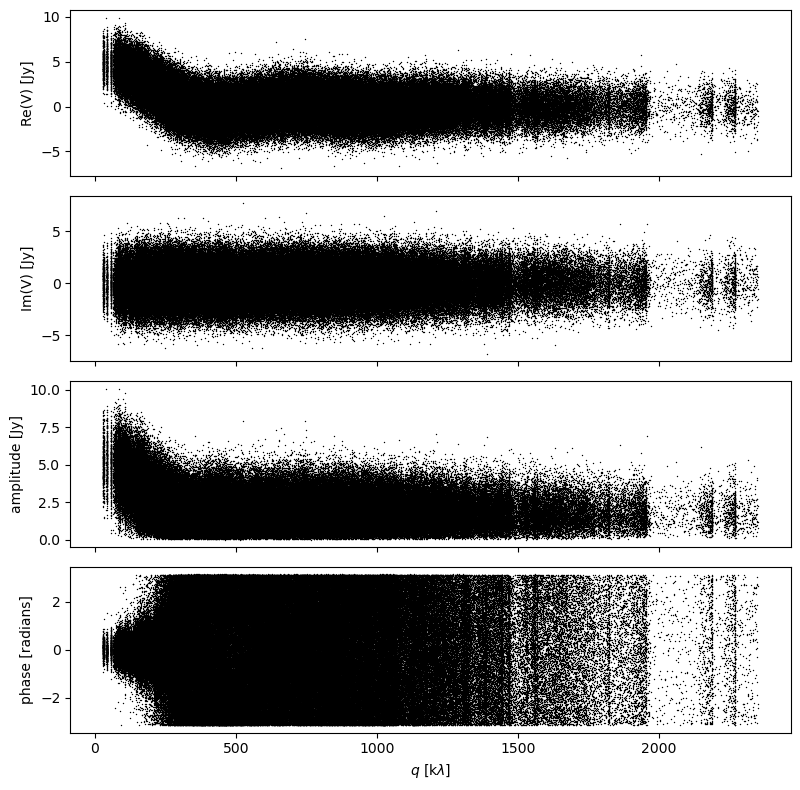

In [4]:
# Use fake visibilities to get dirty image

# load the mock visibilities from the .npz file
d = np.load("../data/visibilities/mock_visibilities_RScl.npz")
#d = np.load("../data/visibilities/mock_visibilities_model_star_new.npz")
uu = d["uu"]
vv = d["vv"]
weight = d["weight"]
data = d["data"]
data_re = np.real(data)
data_im = np.imag(data)

# Plot the downloaded (u,v) distribution
fig, ax = plt.subplots(nrows=1)
ax.scatter(uu, vv, s=1, rasterized=True, linewidths=0.0, c="k")
ax.set_xlabel(r"$u$ [k$\lambda$]")
ax.set_ylabel(r"$v$ [k$\lambda$]")
plt.show()

#calculate the amplitude and phase of the visibilities
amp = np.abs(data)
phase = np.angle(data)

# calculate the uv distance (baseline separations in meters, calculated as sqrt(u*u+v*v))
uvdist = np.hypot(uu, vv)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8, 8))
pkw = {"s":1, "rasterized":True, "linewidths":0.0, "c":"k"}

ax[0].scatter(uvdist, data.real, **pkw)
ax[0].set_ylabel("Re(V) [Jy]")

ax[1].scatter(uvdist, data.imag, **pkw)
ax[1].set_ylabel("Im(V) [Jy]")

ax[2].scatter(uvdist, amp, **pkw)
ax[2].set_ylabel("amplitude [Jy]")

ax[3].scatter(uvdist, phase, **pkw)
ax[3].set_ylabel("phase [radians]")
ax[3].set_xlabel(r"$q$ [k$\lambda$]")

plt.tight_layout()
plt.show()


(1, 128, 128)
(1, 128, 128)


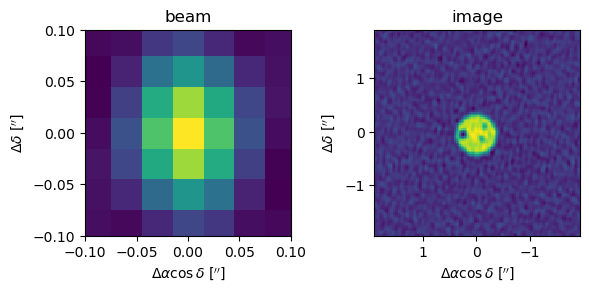

In [5]:
# instantiate the gridcoords object
npix = 128
coords = coordinates.GridCoords(cell_size=cell_size, npix=npix)

# instantiate the dirty imager object
imager = gridding.DirtyImager(
    coords=coords,
    uu=uu,
    vv=vv,
    weight=weight,
    data_re=np.real(data),
    data_im=np.imag(data),
)

# calculate the dirty image and the beam
img, beam = imager.get_dirty_image(weighting="briggs", robust=0.0)

print(beam.shape)
print(img.shape)

# visualise the calculated dirty image and dirty beam
chan = 0
kw = {"origin": "lower", "interpolation": "none", "extent": imager.coords.img_ext}
fig, ax = plt.subplots(ncols=2, figsize=(6, 3))
ax[0].imshow(beam[chan], **kw)
ax[0].set_title("beam")
ax[0].set_xlim(-0.1, 0.1)
ax[0].set_ylim(-0.1, 0.1)
ax[1].imshow(img[chan], **kw)
ax[1].set_title("image")
for a in ax:
    a.set_xlabel(r"$\Delta \alpha \cos \delta$ [${}^{\prime\prime}$]")
    a.set_ylabel(r"$\Delta \delta$ [${}^{\prime\prime}$]")
plt.tight_layout()
plt.show()

28.90215364661027 125.66444797374402
125.66444797374402 222.42674230087775
222.42674230087775 319.1890366280115
319.1890366280115 415.95133095514524
415.95133095514524 512.713625282279
512.713625282279 609.4759196094127
609.4759196094127 706.2382139365465
706.2382139365465 803.0005082636802
803.0005082636802 899.762802590814
899.762802590814 996.5250969179477
996.5250969179477 1093.2873912450814
1093.2873912450814 1190.0496855722151
1190.0496855722151 1286.811979899349
1286.811979899349 1383.5742742264827
1383.5742742264827 1480.3365685536164
1480.3365685536164 1577.0988628807502
1577.0988628807502 1673.861157207884
1673.861157207884 1770.6234515350177
1770.6234515350177 1867.3857458621515
1867.3857458621515 1964.1480401892852
1964.1480401892852 2060.910334516419
2060.910334516419 2157.6726288435525
2157.6726288435525 2254.4349231706865
2254.4349231706865 2351.19721749782


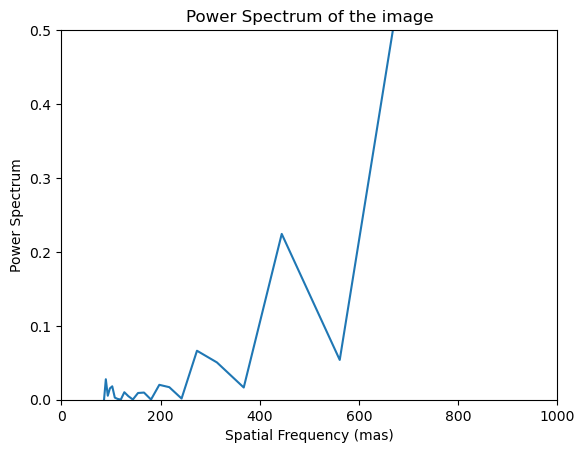

In [9]:

# Make power spectrum from fake visibilities

visibility_file = '../data/visibilities/mock_visibilities_RScl.npz'
n_bins = 100
# power_spectrum_df = make_power_spectrum(visibility_file, n_bins)

baseline = np.sqrt(uu*uu+vv*vv)
nbins=25
uvbin=np.linspace(baseline.min(),baseline.max(),num=nbins,endpoint=True)
duv = uvbin[1]-uvbin[0]

fluxmean_real,fluxstd_real,fluxmean_imag,fluxstd_imag, psd, variance_psd =calcvals(uvbin, baseline, weight,data)
mas = 1/(uvbin+0.5*duv)*180./np.pi*3600
uvd = (uvbin+0.5*duv)
plt.plot(mas,psd)
plt.xlabel('Spatial Frequency (mas)')
plt.ylabel('Power Spectrum')
plt.xlim(0,1000)
plt.ylim(0,0.5)
plt.title('Power Spectrum of the image')
plt.show()
# power_spectrum_df

In [7]:
# plot_power_spectrum('RML_loop_outputs/power_spectrum.csv')